In [36]:
import xarray as xr 
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np 

import sys 
sys.path.append('/home/links/ct715/eddy_feedback')
import functions.eddy_feedback as ef 

In [27]:
ds = xr.open_mfdataset('/home/links/ct715/eddy_feedback/daily_datasets/jra55_djf_ubar_ep.nc',
                            parallel=True, chunks={'time': 31})
ds

<xarray.Dataset>
Dimensions:  (time: 5325, lon: 144, lat: 73, level: 37)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01T09:00:00 ... 2016-12-31T09:00:00
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    v        (time, level, lat, lon) float32 dask.array<chunksize=(31, 37, 73, 144), meta=np.ndarray>
    t        (time, level, lat, lon) float32 dask.array<chunksize=(31, 37, 73, 144), meta=np.ndarray>
    omega    (time, level, lat, lon) float32 dask.array<chunksize=(31, 37, 73, 144), meta=np.ndarray>
    u        (time, level, lat, lon) float32 dask.array<chunksize=(31, 37, 73, 144), meta=np.ndarray>
    ep1      (time, level, lat) float64 dask.array<chunksize=(31, 37, 73), meta=np.ndarray>
    ep2      (time, level, lat) float64 dask.array<chunksize=(31, 37, 73), meta=np.ndarray>
    div1     (time, level, lat) float64 dask.array<chunksize=(31, 37, 73), meta=np.ndarray>
    div2     (time, level, lat) float64 dask.array<chunksize=(31, 37, 73), meta=np.ndarray>
    ubar     (time, level, lat) float32 dask.array<chunksize=(31, 37, 73), meta=np.ndarray>

In [28]:
ubar = ds.ubar
div1 = ds.div1 

ubar = ubar.groupby('time.year').mean('time').load()
div1 = div1.groupby('time.year').mean('time').load() 

ubar = ubar.sel(level=500)
div1 = div1.sel(level=500) 

ubar 

<xarray.DataArray 'ubar' (year: 59, lat: 73)>
array([[-2.3109531e-05,  5.3980254e-02,  4.6276626e-01, ...,
         7.6349926e-01, -1.4774023e-01, -2.4286912e-05],
       [ 9.2308605e-05,  2.3114536e+00,  4.0373363e+00, ...,
         1.7550163e-01, -2.5561821e-01,  6.6366316e-05],
       [-8.0672226e-06,  1.3559436e+00,  1.6017816e+00, ...,
         1.7514433e-01, -3.6425728e-02, -9.7486718e-06],
       ...,
       [-4.1907515e-05,  3.8895553e-01,  6.9325048e-01, ...,
         2.5681809e-01, -6.4738482e-01,  2.0674723e-05],
       [-7.4056920e-06,  4.6328542e-01,  1.0966651e+00, ...,
         2.0987451e-01, -4.2418152e-01,  3.4473578e-06],
       [-7.2703413e-05,  7.6325518e-01,  1.6179562e+00, ...,
        -3.7134007e-01, -3.9882565e-01,  3.9903240e-05]], dtype=float32)
Coordinates:
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
    level    float64 500.0
  * year     (year) int64 1958 1959 1960 1961 1962 ... 2012 2013 2014 2015 2016

In [38]:
def calculate_ef_parameter(div1, ubar):

    """ 
    Input: Xarray dataArrays of ubar and div1 (year, lat)

    Output: Xarray dataArray of Eddy Feedback Parameter (EFP)
    """

    # calculate Pearson's correlation between the two variables
    R = xr.corr(div1, ubar, dim='year')

    # correlation squared
    R = R**2

    # print(R.values)

    # take EFP slice of Lats 25-72:
    R = R.sel(lat=slice(72,25))
    

    import numpy as np
    RR = R*np.cos( np.deg2rad(ds.lat) )

    R_weighted = RR.sum('lat') / (np.cos( np.deg2rad(ds.lat) )).sum('lat')
    R_weighted.values 

    return R_weighted.values, RR 



In [39]:
EFP, RR = calculate_ef_parameter(div1, ubar)
EFP

array(0.07157513)

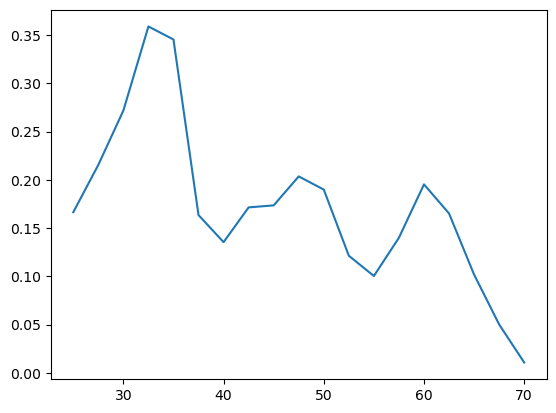

In [37]:
plt.plot(EFP.lat.values, EFP.values)

# Weighted seasonal means